In [1]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
# !pip install tsfresh
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy
from itertools import combinations
import pandas as pd

from sklearn.linear_model import LinearRegression as LR  # 线性回归

from tsfresh import extract_features, extract_relevant_features, select_features

from tsfresh.feature_selection.relevance import calculate_relevance_table
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LinearRegression as LR  # 线性回归
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif


In [2]:
# peaks detection from Yida
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, duration, sampling_rate):
    max = np.max(data_tmp)
    data_tmp = data_tmp / max

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal) 

    t_peaks = t[peak_indices] 
    peak_values = signal[peak_indices]  
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=10)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2


In [3]:
# basic features extraction
def calculate_entropy(signal):
    prob_distribution = np.histogram(signal, bins=10, density=True)[0]
    ent = entropy(prob_distribution)
    return ent


def calculate_centroid(signal):
    centroid = np.sum(np.arange(len(signal)) * np.abs(signal)) / np.sum(np.abs(signal))
    return centroid

def calculate_spectral_entropy(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    prob_distribution = Pxx / np.sum(Pxx)
    spec_entropy = entropy(prob_distribution)
    return spec_entropy


def calculate_spectral_centroid(signal, fs):
    f, Pxx = welch(signal, fs=fs)
    spectral_centroid = np.sum(f * Pxx) / np.sum(Pxx)
    return spectral_centroid


def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    max_index = np.argmax(filtered_a)
    min_index = np.argmin(filtered_a)
    filtered_a = np.delete(filtered_a, [max_index, min_index])

    max_index = np.argmax(filtered_a)
    min_index = np.argmin(filtered_a)
    filtered_a = np.delete(filtered_a, [max_index, min_index])
    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

# get essential features
def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    # mag_0 = get_mag_0(peaks2, data_tmp_raw)
    # mag_1 = get_mag_1(peaks2, data_tmp_raw)
    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    # features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])
    features = [m_12, m_21, m_22, mag_0, mag_1]

    return features


def get_other_features(signal, fs):
    signal /= np.max(signal)
    # spectrum
    spec_entropy = calculate_spectral_entropy(signal, fs)
    spec_centroid = calculate_spectral_centroid(signal, fs)
    # power_bandwidth = calculate_power_bandwidth(signal, fs)

    features_spec_list = [spec_entropy, spec_centroid]

    # others
    maximum = np.max(signal)
    minimum = np.min(signal)
    mean = np.mean(signal)
    median = np.median(signal)

    mean_abs_difference = np.mean(np.abs(np.diff(signal)))
    mean_difference = np.mean(np.diff(signal))
    sum_abs_difference = np.sum(np.abs(np.diff(signal)))
    rms = np.sqrt(np.mean(np.square(signal)))
    entropy = calculate_entropy(signal)
    centroid = calculate_centroid(signal)
    kurt = kurtosis(signal)
    skeww = skew(signal)

    zero_crossing_rate = len(signal[signal > 0]) / len(signal)
    # energy = np.sum(signal ** 2)

    features_other_list = [maximum, minimum, mean, median, mean_abs_difference, mean_difference, sum_abs_difference,
                        rms, entropy, centroid, kurt, skeww,zero_crossing_rate]

    return features_spec_list + features_other_list


In [4]:
# features enhancement based on features intersaction
def intersation(features_train, features_str, features_idx):
    features_combination = list(combinations(features_idx, 2))
    combined_str = []
    combined_features = []

    for comb in features_combination:
        print(comb)
        idx_1 = comb[0]
        idx_2 = comb[1]
        feature_a = features_train[:, idx_1]
        feature_b = features_train[:, idx_2]
        # add
        a_add_b = feature_a + feature_b
        a_add_b_str = features_str[idx_1] + '_add_' + features_str[idx_2]
        combined_str.append(a_add_b_str)
        combined_features.append(a_add_b)

        # minus
        a_minus_b = feature_a - feature_b
        a_minus_b_str = features_str[idx_1] + '_minus_' + features_str[idx_2]
        combined_str.append(a_minus_b_str)
        combined_features.append(a_minus_b)

        # mutli
        a_multi_b = feature_a * feature_b
        a_multi_b_str = features_str[idx_1] + '_multi_' + features_str[idx_2]
        combined_str.append(a_multi_b_str)
        combined_features.append(a_multi_b)

        # divide 
        b_divide_a = feature_a / feature_b
        b_divide_a_str = features_str[idx_2] + '_divide_' + features_str[idx_1]
        combined_str.append(b_divide_a_str)
        combined_features.append(b_divide_a)
    
    return np.array(combined_features), combined_str

In [5]:
if __name__ == '__main__':

    # # load data 0.1
    # fs = 100
    # sampling_rate = 100
    # duration = 10

    # data_train = np.load('../Data/NewTry/sim_5000_0.1_90_140_train.npy')
    # data_test = np.load('../Data/NewTry/sim_3000_0.1_141_178_test.npy')

    # signals_train, S_train, D_train = data_train[:, :1000], data_train[:, -2], data_train[:, -1]
    # signals_test, S_test, D_test = data_test[:, :1000], data_test[:, -2], data_test[:, -1]
    
    # important_features_str =  ['Dis12', 'Dis21', 'Dis22', 'P1', 'P2']
    # other_features_str = ['spec_entropy', 'spec_centroid', 'max', 'min', 'mean', 'median', 'mean_abs_diff', 'mean_diff', 'sum_abs_diff', 
    #                     'rms', 'entropy', 'centroid', 'kurt', 'skew', 'zeore_crossing_rate']

    # features_str = important_features_str + other_features_str

    # index_train, index_test = [], []
    # features_train, features_test = [], []

    # for i, signal in enumerate(signals_train):
    #     peaks = get_peaks(signal, duration, sampling_rate)
    #     if len(peaks) < 16 or max(signal) > 1: 
    #         # print(len(peaks))
    #         # # continue
    #         # plt.figure()
    #         # plt.plot(signal)
    #         # plt.scatter(peaks, signal[peaks]) 
    #         continue
    #     index_train.append(i)
    #     important_features = get_features(signal, peaks)
    #     other_features = get_other_features(signal, fs)
    #     features = important_features + other_features
    #     features_train.append(features)

    # features_train = np.array(features_train)

    # for i, signal in enumerate(signals_test):
    #     peaks = get_peaks(signal, duration, sampling_rate)
    #     if len(peaks) < 16 or max(signal) > 1:
    #         continue
    #     index_test.append(i)
    #     important_features = get_features(signal, peaks)
    #     other_features = get_other_features(signal, fs)
    #     features = important_features + other_features
    #     features_test.append(features)

    # features_test = np.array(features_test)

    # # features_train.shape, features_test.shape, S_train[index_train].shape, S_test[index_test].shape


    # def combinations_get_features(features_train, features_str, index):

    #     important_features_idx = [0, 1, 2, 3, 4]
    #     other_features_idx = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

    #     important_combined_features, important_combined_str = intersation(features_train, features_str, important_features_idx)
    #     other_combined_features, other_combined_str = intersation(features_train, features_str, other_features_idx)
    #     combined_features = np.concatenate((features_train, np.concatenate((important_combined_features, other_combined_features)).T), 1)
    #     combined_str = features_str + important_combined_str + other_combined_str
    #     combined_features_pd = pd.DataFrame(combined_features, index=index, columns=combined_str)

    #     return combined_features_pd, combined_str

    # combined_features_train_pd, combined_str = combinations_get_features(features_train, features_str, index_train)
    # combined_features_test_pd, combined_str = combinations_get_features(features_test, features_str, index_test)

    # scaler = MinMaxScaler()
    # scaler.fit(combined_features_train_pd)

    # combined_features_train_normal_np= scaler.transform(combined_features_train_pd)
    # combined_features_test_normal_np= scaler.transform(combined_features_test_pd)

    # combined_features_train_normal_pd = pd.DataFrame(combined_features_train_normal_np, index=index_train, columns=combined_str)
    # combined_features_train_normal_pd.to_csv('../Data/NewTry/combined_features_0.1_train_normal.csv')

    # combined_features_test_normal_pd = pd.DataFrame(combined_features_test_normal_np, index=index_test, columns=combined_str)
    # combined_features_test_normal_pd.to_csv('../Data/NewTry/combined_features_0.1_test_normal.csv')

    # S_train_pd = pd.Series(S_train[index_train], index=index_train)
    # D_train_pd = pd.Series(D_train[index_train], index=index_train)
    # S_train_pd.to_csv('../Data/NewTry/S_0.1_train.csv')
    # D_train_pd.to_csv('../Data/NewTry/D_0.1_train.csv')

    # S_test_pd = pd.Series(S_test[index_test], index=index_test)
    # D_test_pd = pd.Series(D_test[index_test], index=index_test)
    # S_test_pd.to_csv('../Data/NewTry/S_0.1_test.csv')
    # D_test_pd.to_csv('../Data/NewTry/D_0.1_test.csv')

    combined_features_train_normal_pd = pd.read_csv('../Data/NewTry/combined_features_0.1_train_normal.csv', index_col=0)
    combined_features_test_normal_pd = pd.read_csv('../Data/NewTry/combined_features_0.1_test_normal.csv', index_col=0)
    S_train_pd = pd.read_csv('../Data/NewTry/S_0.1_train.csv', index_col=0).iloc[:, 0]
    D_train_pd = pd.read_csv('../Data/NewTry/D_0.1_train.csv', index_col=0).iloc[:, 0]
    S_test_pd = pd.read_csv('../Data/NewTry/S_0.1_test.csv', index_col=0).iloc[:, 0]
    D_test_pd = pd.read_csv('../Data/NewTry/D_0.1_test.csv',index_col=0).iloc[:, 0]


    # step 1. use select features to filter some low p-value features
    features_selected_S = select_features(combined_features_train_normal_pd, S_train_pd)
    features_selected_D = select_features(combined_features_train_normal_pd, D_train_pd)

    print('Step 1.')

    print('----All extracted features----')
    print(combined_features_train_normal_pd.shape)
    print(combined_features_train_normal_pd.columns)
    print()

    print('----Selected features for S----')
    print(features_selected_S.shape)
    print(features_selected_S.columns)
    print()

    print('----Selected features for D----')
    print(features_selected_D.shape)
    print(features_selected_D.columns)
    print()

    print('----Relevance Table----')

    print('----Relevance Table of S----')
    relevance_table_S = calculate_relevance_table(combined_features_train_normal_pd, S_train_pd)
    print(relevance_table_S)
    print()

    print('----Relevance Table of D----')
    relevance_table_D = calculate_relevance_table(combined_features_train_normal_pd, D_train_pd)
    print(relevance_table_D)
    print()


Step 1.
----All extracted features----
(4718, 480)
Index(['Dis12', 'Dis21', 'Dis22', 'P1', 'P2', 'spec_entropy', 'spec_centroid',
       'max', 'min', 'mean',
       ...
       'kurt_multi_skew', 'skew_divide_kurt', 'kurt_add_zeore_crossing_rate',
       'kurt_minus_zeore_crossing_rate', 'kurt_multi_zeore_crossing_rate',
       'zeore_crossing_rate_divide_kurt', 'skew_add_zeore_crossing_rate',
       'skew_minus_zeore_crossing_rate', 'skew_multi_zeore_crossing_rate',
       'zeore_crossing_rate_divide_skew'],
      dtype='object', length=480)

----Selected features for S----
(4718, 428)
Index(['mean_diff_multi_entropy', 'median_minus_skew',
       'entropy_minus_zeore_crossing_rate', 'entropy_add_zeore_crossing_rate',
       'skew_divide_entropy', 'mean_abs_diff_add_entropy',
       'entropy_minus_skew', 'Dis22_divide_Dis21', 'entropy_add_skew',
       'kurt_divide_entropy',
       ...
       'mean_multi_skew', 'P1_add_P2', 'min_add_rms',
       'spec_centroid_add_centroid', 'spec_entr

In [7]:


    print('Step 2.')
    
    # features_new_S = SelectKBest(f_classif, k=3).fit_transform(features_selected_S, S_train_pd)
    S_selector_f = SelectKBest(f_classif, k=3)
    features_new_S_f = S_selector_f.fit_transform(features_selected_S, S_train_pd)
    mask_S_f = S_selector_f.get_support()
    features_new_S_f_str = features_selected_S.columns[mask_S_f]
    
    S_selector_mutual = SelectKBest(mutual_info_classif, k=3)
    features_new_S_mutual = S_selector_mutual.fit_transform(features_selected_S, S_train_pd)
    mask_S_mutual = S_selector_mutual.get_support()
    features_new_S_mutual_str = features_selected_S.columns[mask_S_mutual]

    final_features_S_str = set(list(features_new_S_f_str) + list(features_new_S_mutual_str))
    print(final_features_S_str)


    # features_new_D = SelectKBest(mutual_info_classif, k=3).fit_transform(features_selected_D, D_train_pd)
    D_selector_f = SelectKBest(f_classif, k=3)
    features_new_D_f = D_selector_f.fit_transform(features_selected_D, D_train_pd)
    mask_D_f = D_selector_f.get_support()
    features_new_D_f_str = features_selected_D.columns[mask_D_f]
    # print(list(features_new_D_str))

    # features_new_D = SelectKBest(mutual_info_classif, k=3).fit_transform(features_selected_D, D_train_pd)
    D_selector_mutual = SelectKBest(mutual_info_classif, k=3)
    features_new_D_mutual = D_selector_mutual.fit_transform(features_selected_D, D_train_pd)
    mask_D_mutual = D_selector_mutual.get_support()
    features_new_D_mutual_str = features_selected_D.columns[mask_D_mutual]
    final_features_D_str = set(list(features_new_D_f_str) + list(features_new_D_mutual_str))
    print(final_features_D_str)


# X_new, features_selected_S
# X_new, features_selected_S

Step 2.
{'Dis21_divide_Dis12', 'Dis22_divide_Dis12', 'Dis22_divide_Dis21'}
{'P1_multi_P2', 'Dis22_minus_P2', 'P2', 'P2_divide_P1', 'Dis22_add_P2'}


---S---
{'Dis21_divide_Dis12', 'Dis22_divide_Dis12', 'Dis22_divide_Dis21'}
Optimal number of features: 1
[1 3 2]

---D---
{'P1_multi_P2', 'Dis22_minus_P2', 'P2', 'P2_divide_P1', 'Dis22_add_P2'}
Optimal number of features: 4
[2 1 1 1 1]


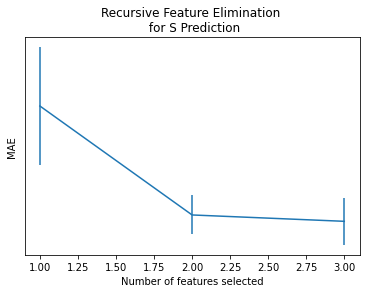

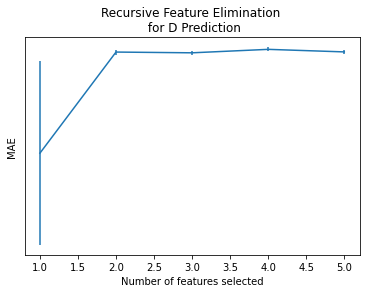

In [12]:
def rfecv(X_new, test_pd, label):

    min_features_to_select = 1  
    clf = LR()
    cv = StratifiedKFold(6)

    rfecv = RFECV(
        estimator=clf,
        step=1,
        cv=cv,
        scoring="neg_mean_absolute_error",
        min_features_to_select=min_features_to_select,
        n_jobs=2,
    )

    rfecv.fit(X_new, test_pd)

    print(f"Optimal number of features: {rfecv.n_features_}")

    import matplotlib.pyplot as plt

    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("MAE")
    plt.yticks([])
    plt.errorbar(
        range(min_features_to_select, n_scores + min_features_to_select),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("Recursive Feature Elimination \n for "+ label + " Prediction")
    # plt.show()
    path = '../Pic/8.21/rfecv_'+label+'.jpg'
    plt.savefig(path, dpi=300)

    return rfecv.ranking_

print('---S---')
print(final_features_S_str)
print(rfecv(features_selected_S[list(final_features_S_str)], S_train_pd, "S"))

print()

print('---D---')
print(final_features_D_str)
print(rfecv(features_selected_D[list(final_features_D_str)], D_train_pd, "D"))

Saved plot to S.png


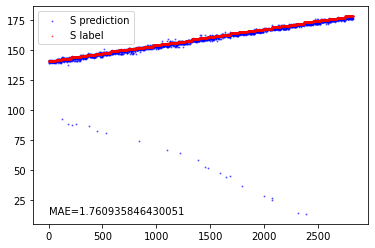

Saved plot to D4.png


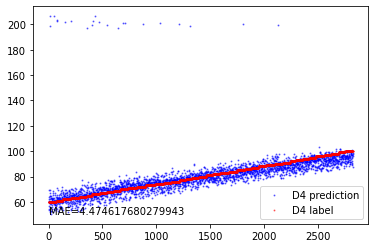

Saved plot to D1.png


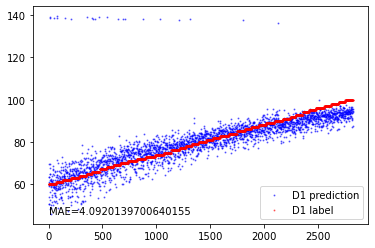

In [18]:
def linearRegression(x, y, x_test, y_test_real):
    reg = LR().fit(x, y)
    yhat = reg.predict(x_test)
    return np.mean(np.abs(yhat - y_test_real)), yhat

D_features = ['Dis22_minus_P2', 'P2', 'Dis22_add_P2', 'P2_divide_P1']
S_features = ['Dis21_divide_Dis12']

lgS, S_predict = linearRegression(features_selected_S[S_features], S_train_pd, combined_features_test_normal_pd[S_features], S_test_pd)
lgD_4, D4_predict = linearRegression(features_selected_D[D_features], D_train_pd, combined_features_test_normal_pd[D_features], D_test_pd)
lgD_1, D1_predict = linearRegression(np.array(features_selected_D['P2_divide_P1']).reshape(-1, 1), D_train_pd, np.array(combined_features_test_normal_pd['P2_divide_P1']).reshape(-1, 1), D_test_pd)

lgS, lgD_1, lgD_4

from utils import plot_2vectors

plot_2vectors(np.array(S_test_pd), S_predict, "S")
plot_2vectors(np.array(D_test_pd), D4_predict, "D4")
plot_2vectors(np.array(D_test_pd), D1_predict, "D1")